/var/folders/y5/gpdc5fcj7yn14_gxnjxr8qkw0000gn/T/ipykernel_65551/4255298425.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("30T").mean()
/var/folders/y5/gpdc5fcj7yn14_gxnjxr8qkw0000gn/T/ipykernel_65551/4255298425.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_profiles = daily_profiles.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)


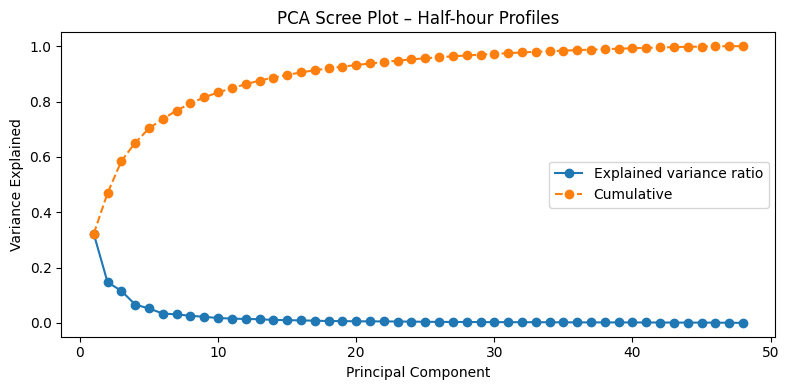

Chosen PCs (>=90% variance): K = 16


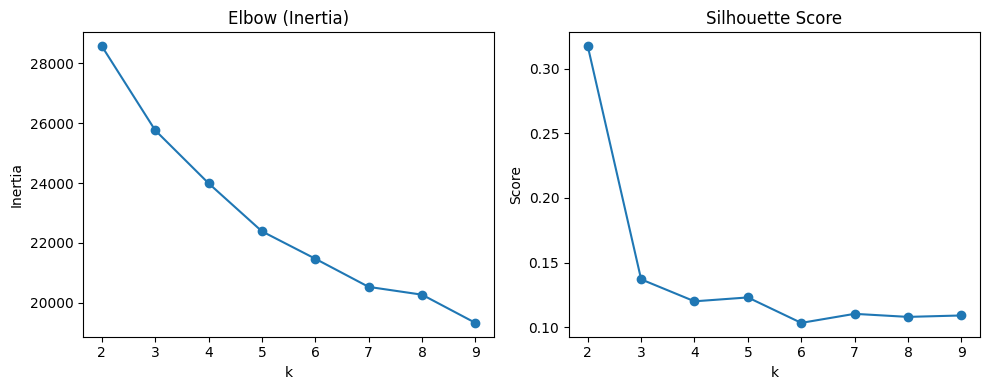

cluster
0    299
1    241
2     96
3    210
Name: count, dtype: int64


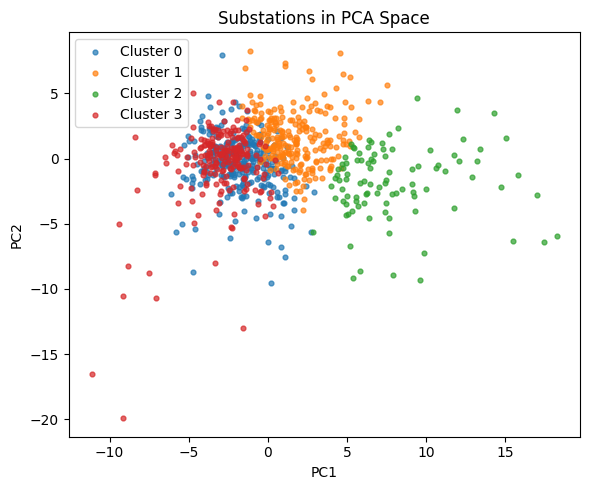

In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os

cwd = os.getcwd()

file_name = "//ukpn-smart-meter-consumption-substation.csv"

file_path = cwd + file_name

# read into pandas 

csv_read = pd.read_csv(file_path)

df = pd.DataFrame(csv_read)

# Keep only what we need
desired_cols = ["secondary_substation_id", "data_collection_log_timestamp",
                "total_consumption_active_import"]
df2 = df[desired_cols].copy()

# Datetime (handle tz if present)
df2["data_collection_log_timestamp"] = pd.to_datetime(df2["data_collection_log_timestamp"], errors="coerce")
df2 = df2.dropna(subset=["data_collection_log_timestamp"])

# Resample to 30-min per substation
df2 = df2.set_index("data_collection_log_timestamp")
hh = (df2
      .groupby("secondary_substation_id")["total_consumption_active_import"]
      .resample("30T").mean()
      .reset_index())

# Half-hour slot 
hh["half_hour_slot"] = hh["data_collection_log_timestamp"].dt.hour * 2 + (hh["data_collection_log_timestamp"].dt.minute // 30)

# Average daily profile per substation: 48 columns 
daily_profiles = (hh
    .groupby(["secondary_substation_id", "half_hour_slot"])["total_consumption_active_import"]
    .mean()
    .unstack(fill_value=np.nan)  
)

# drop profiles missing many slots 
min_slots = 40
daily_profiles = daily_profiles[daily_profiles.notna().sum(axis=1) >= min_slots]
daily_profiles = daily_profiles.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)

# normalise each substation profile by its mean to focus on shape
profiles_shape = daily_profiles.div(daily_profiles.mean(axis=1), axis=0)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = profiles_shape.values  # shape-only profiles 
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=48)   # max is number of features (48 half-hour slots)
Xp = pca.fit_transform(Xz)

# Scree plot (explained variance ratio)
evr = pca.explained_variance_ratio_
cum_evr = evr.cumsum()

plt.figure(figsize=(8,4))
plt.plot(range(1, len(evr)+1), evr, marker='o', label='Explained variance ratio')
plt.plot(range(1, len(cum_evr)+1), cum_evr, marker='o', linestyle='--', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Scree Plot – Half-hour Profiles')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

# Choose number of PCs 
K = int(np.argmax(cum_evr >= 0.90)) + 1
print(f"Chosen PCs (>=90% variance): K = {K}")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

XpK = Xp[:, :K]  # retain first K PCs

inertias, sils = [], []
k_range = range(2, 10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(XpK)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(XpK, labels))

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(list(k_range), inertias, marker='o')
ax[0].set_title('Elbow (Inertia)')
ax[0].set_xlabel('k'); ax[0].set_ylabel('Inertia'); ax[0]
plt.grid(False)
ax[1].plot(list(k_range), sils, marker='o')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('k'); ax[1].set_ylabel('Score'); ax[1]
plt.grid(False)
plt.tight_layout(); plt.show()

# Pick k 
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(XpK)

# Attach labels back to substations
profiles_with_labels = profiles_shape.copy()
profiles_with_labels["cluster"] = cluster_labels
profiles_with_labels.index.name = "secondary_substation_id"

# Quick counts
print(profiles_with_labels["cluster"].value_counts().sort_index())

plt.figure(figsize=(6,5))
for c in sorted(np.unique(cluster_labels)):
    mask = cluster_labels == c
    plt.scatter(XpK[mask, 0], XpK[mask, 1], s=12, label=f'Cluster {c}', alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Substations in PCA Space')
plt.legend()
plt.grid((False)); plt.tight_layout(); plt.show()





PC1 top + slots:
slot_06    0.218895
slot_07    0.216184
slot_08    0.212228
slot_05    0.205757
slot_09    0.197514
Name: PC1, dtype: float64
PC1 top - slots:
slot_24   -0.190841
slot_26   -0.187522
slot_22   -0.187383
slot_25   -0.186709
slot_27   -0.183177
Name: PC1, dtype: float64

PC2 top + slots:
slot_44    0.279020
slot_43    0.273573
slot_46    0.268403
slot_42    0.263440
slot_45    0.254457
Name: PC2, dtype: float64
PC2 top - slots:
slot_16   -0.202995
slot_19   -0.201242
slot_17   -0.199377
slot_18   -0.179105
slot_20   -0.173680
Name: PC2, dtype: float64

PC3 top + slots:
slot_37    0.280931
slot_38    0.264870
slot_36    0.263621
slot_39    0.239908
slot_15    0.223063
Name: PC3, dtype: float64
PC3 top - slots:
slot_00   -0.190333
slot_28   -0.186650
slot_01   -0.184656
slot_29   -0.184621
slot_27   -0.177322
Name: PC3, dtype: float64


/var/folders/y5/gpdc5fcj7yn14_gxnjxr8qkw0000gn/T/ipykernel_65551/1898960927.py:44: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_labels = pd.date_range('00:00', '23:30', freq='30T').strftime('%H:%M')


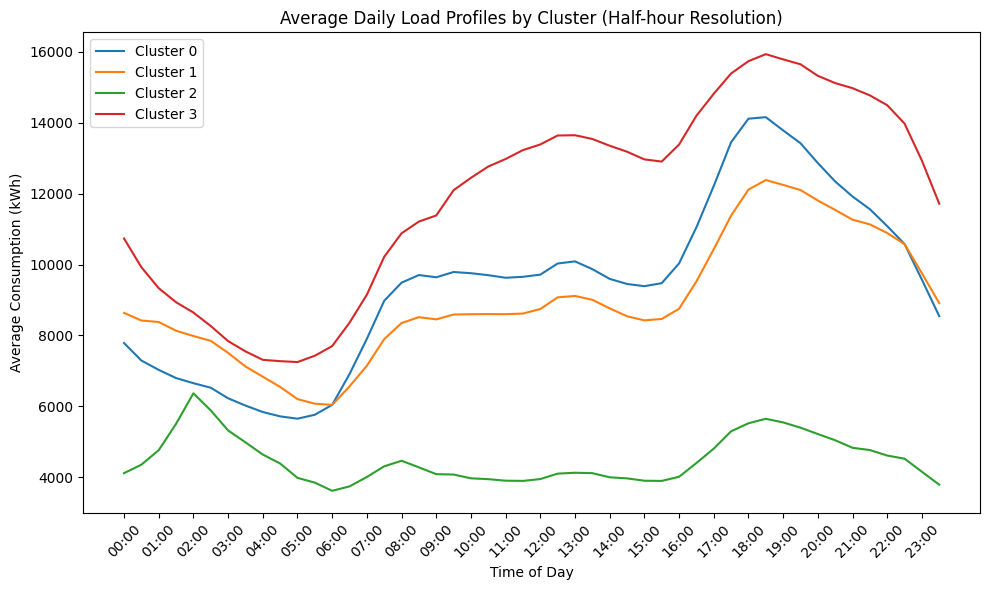

In [12]:
loadings = pd.DataFrame(pca.components_[:K, :],  # K PCs
                        columns=[f'slot_{i:02d}' for i in range(48)],
                        index=[f'PC{i+1}' for i in range(K)])
# Top +/− contributing slots for PC1/PC2
for i in range(min(3, K)):
    pc = loadings.iloc[i]
    top_pos = pc.nlargest(5)
    top_neg = pc.nsmallest(5)
    print(f"\nPC{i+1} top + slots:\n{top_pos}\nPC{i+1} top - slots:\n{top_neg}")

# Map cluster labels back to half-hourly rows 

# profiles_with_labels: index=substation_id, column 'cluster'
label_map = profiles_with_labels['cluster']

# Add cluster to the half-hourly table `hh`
hh = hh.merge(
    label_map,
    left_on="secondary_substation_id",
    right_index=True,
    how="left"
)

# drop rows without a cluster 
hh = hh.dropna(subset=['cluster'])
hh['cluster'] = hh['cluster'].astype(int)

avg_profiles = (
    hh.groupby(['cluster', 'half_hour_slot'])['total_consumption_active_import']
      .mean()
      .reset_index()
)

# Make a pivot for convenient plotting 
avg_profiles_wide = avg_profiles.pivot(index='cluster', columns='half_hour_slot',
                                       values='total_consumption_active_import')

# Plot with clock-style x-axis labels 

# Build tick labels
time_labels = pd.date_range('00:00', '23:30', freq='30T').strftime('%H:%M')

plt.figure(figsize=(10, 6))
for c in sorted(avg_profiles['cluster'].unique()):
    series = avg_profiles_wide.loc[c].reindex(range(48)) 
    plt.plot(range(48), series.values, label=f'Cluster {c}')

plt.xticks(ticks=range(0, 48, 2), labels=time_labels[::2], rotation=45)  
plt.xlabel('Time of Day')
plt.ylabel('Average Consumption (kWh)')
plt.title('Average Daily Load Profiles by Cluster (Half-hour Resolution)')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()